In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
pd.set_option('display.max_rows', None)
import plotly.offline as py
import plotly.graph_objects as go
import plotly.express as px
from IPython.display import HTML,display,display_html

from scipy import linalg
from sklearn.decomposition import NMF

from tqdm import tqdm

In [2]:
import warnings

warnings.simplefilter(action="ignore")

# Player Recommender System

### Load Data / Preprocessing

In [3]:
df = pd.read_csv(r'data/players_15.csv')

In [4]:
df.head()

,sofifa_id,player_url,short_name,long_name,age,dob,height_cm,weight_kg,nationality,club,...,lwb,ldm,cdm,rdm,rwb,lb,lcb,cb,rcb,rb
0,158023,https://sofifa.com/player/158023/lionel-messi/...,L. Messi,Lionel Andrés Messi Cuccittini,27,1987-06-24,169,67,Argentina,FC Barcelona,...,62+3,62+3,62+3,62+3,62+3,54+3,45+3,45+3,45+3,54+3
1,20801,https://sofifa.com/player/20801/c-ronaldo-dos-...,Cristiano Ronaldo,Cristiano Ronaldo dos Santos Aveiro,29,1985-02-05,185,80,Portugal,Real Madrid,...,63+3,63+3,63+3,63+3,63+3,57+3,52+3,52+3,52+3,57+3
2,9014,https://sofifa.com/player/9014/arjen-robben/15...,A. Robben,Arjen Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,...,64+3,64+3,64+3,64+3,64+3,55+3,46+3,46+3,46+3,55+3
3,41236,https://sofifa.com/player/41236/zlatan-ibrahim...,Z. Ibrahimović,Zlatan Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,...,61+3,65+3,65+3,65+3,61+3,56+3,55+3,55+3,55+3,56+3
4,167495,https://sofifa.com/player/167495/manuel-neuer/...,M. Neuer,Manuel Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_reduced = df[['height_cm','weight_kg','weak_foot','skill_moves','work_rate','body_type','pace','shooting','passing','dribbling','defending','physic','attacking_crossing','attacking_finishing','attacking_heading_accuracy','attacking_short_passing','attacking_volleys','skill_dribbling','skill_curve','skill_fk_accuracy','skill_long_passing','skill_ball_control','movement_acceleration','movement_sprint_speed','movement_agility','movement_balance']]
df_reduced.head()

,height_cm,weight_kg,weak_foot,skill_moves,work_rate,body_type,pace,shooting,passing,dribbling,...,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_balance
0,169,67,3,4,Medium/Low,Normal,93.0,89.0,86.0,96.0,...,85-5,96-1,89+2,90+4,76,96,96,90+2,94,95
1,185,80,4,5,High/Low,Normal,93.0,93.0,81.0,91.0,...,87+2,93+3,88,79,72,92-3,91,94,93,63-12
2,180,80,2,4,High/Low,Normal,93.0,86.0,83.0,92.0,...,86+2,93,85,83-1,76+3,90+1,93,93+2,93+1,91
3,195,95,4,4,Medium/Low,Normal,76.0,91.0,81.0,86.0,...,92+3,88,80,80,76+4,90,74+2,77-1,86,41
4,193,92,4,1,Medium/Medium,Normal,NaN,NaN,NaN,NaN,...,25,25,25,25,41,31,58+8,61+7,43+4,35


### Ordinal Encoding for the work_rate variable

In [6]:
df_reduced['work_rate'].unique()

array(['Medium/Low', 'High/Low', 'Medium/Medium', 'High/Medium',
       'High/High', 'Medium/High', 'Low/Medium', 'Low/High', 'Low/Low'],
      dtype=object)

In [7]:
# Define the unique values and their corresponding numbers
value_to_number = {'Low/Low': 0, 'Low/Medium': 1, 'Low/High': 2,
                   'Medium/Low': 3, 'Medium/Medium': 4, 'Medium/High': 5,
                   'High/Low': 6, 'High/Medium': 7, 'High/High': 8}

# Encode the original array into numbers
c = df_reduced['work_rate']
df_reduced['work_rate'] = [value_to_number[wr] for wr in c]


### Convert important string data into numbers

#### Instead of vague and broad descriptions such as 'Normal', ' Lean', and 'Stocky', replace these string values with BMI (weight/height^2)

In [8]:
df_reduced['body_type'].unique()

array(['Normal', 'Lean', 'Stocky'], dtype=object)

In [9]:
df_reduced['body_type'] = df_reduced['weight_kg']/(df_reduced['height_cm']/100)**2

In [10]:
for column in df_reduced.columns:
    c = df_reduced[column]
    for i, value in enumerate(c):
        if isinstance(value,str) and ('-' in value or '+' in value):
            df_reduced[column] = eval(value)

In [11]:
df_reduced.head()

,height_cm,weight_kg,weak_foot,skill_moves,work_rate,body_type,pace,shooting,passing,dribbling,...,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_balance
0,169,67,3,4,3,23.458562,93.0,89.0,86.0,96.0,...,41,61,30,77,23,21,38,34,53,89
1,185,80,4,5,6,23.374726,93.0,93.0,81.0,91.0,...,41,61,30,77,23,21,38,34,53,89
2,180,80,2,4,6,24.691358,93.0,86.0,83.0,92.0,...,41,61,30,77,23,21,38,34,53,89
3,195,95,4,4,3,24.983563,76.0,91.0,81.0,86.0,...,41,61,30,77,23,21,38,34,53,89
4,193,92,4,1,4,24.698650,NaN,NaN,NaN,NaN,...,41,61,30,77,23,21,38,34,53,89


In [12]:
df_reduced.isna().sum()

height_cm                        0
weight_kg                        0
weak_foot                        0
skill_moves                      0
work_rate                        0
body_type                        0
pace                          1703
shooting                      1703
passing                       1703
dribbling                     1703
defending                     1703
physic                        1703
attacking_crossing               0
attacking_finishing              0
attacking_heading_accuracy       0
attacking_short_passing          0
attacking_volleys                0
skill_dribbling                  0
skill_curve                      0
skill_fk_accuracy                0
skill_long_passing               0
skill_ball_control               0
movement_acceleration            0
movement_sprint_speed            0
movement_agility                 0
movement_balance                 0
dtype: int64

In [13]:
df_reduced.shape

(15465, 26)

In [14]:
# Get boolean mask of NaN values
nan_mask = pd.isna(df_reduced)

# Get index of rows with NaN values
nan_rows = nan_mask.any(axis=1)
nan_rows = nan_rows[nan_rows == True].index

# Get index of columns with NaN values
nan_cols = [6,7,8,9,10,11]

In [77]:
def initialize(mat):
    """
    Fill in missing values (NAs) with zeros.
    """
    for col in nan_cols:
        for row in nan_rows:
            mat.iloc[row,col] = np.nanmean(mat[mat.columns[col]])
    return mat

def maxim_svd(mat, k):
    """
    Iterative algorithm for matrix factorization using SVD.
    """
    u, s, vt = linalg.svd(mat, full_matrices=False)
    u_k = u[:, :k]
    s_k = np.diag(s[:k])
    vt_k = vt[:k, :]
    
    return np.matmul(np.matmul(u_k,s_k),vt_k)

def recommender(mat, maxim, num_steps, k):
    """
    EM algorithm for matrix factorization using SVD.
    """
    mat2 = initialize(mat)
    loss = np.zeros(num_steps)
    
    for j in tqdm(range(num_steps)):
        loss_j = 0
        if maxim == maxim_nmf:
            res,err = maxim(mat2, k)
            mat2 = pd.DataFrame(res)
            mat2.iloc[row,col] = mat.iloc[row,col]
            loss[j] = err
        else:
            res= maxim(mat2, k)
            mat2 = pd.DataFrame(res)
            for col in nan_cols:
                for row in nan_rows:
                    loss_j += (mat.iloc[row,col]-mat2.iloc[row,col])**2
            loss[j] = loss_j
            mat2.iloc[row,col] = mat.iloc[row,col]
    
    plt.plot(loss)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.show()
    
    return loss, mat2

### Using an iterative method with dimensionality reduction measures to impute missing data

### SVD 

100%|████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:05<00:00,  1.88it/s]


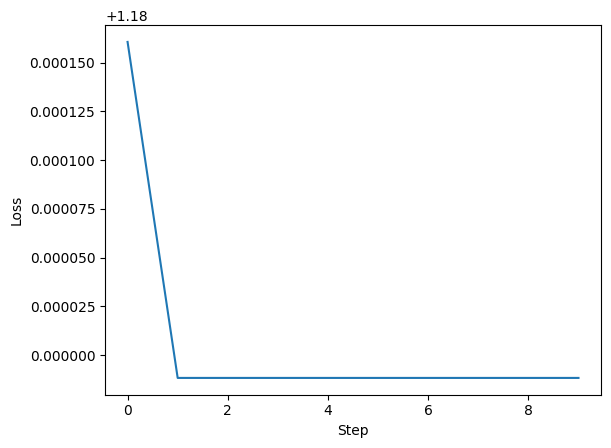

In [78]:
svd_loss, svd_mat = recommender(df_reduced, maxim = maxim_svd,num_steps=10, k=10)

### NMF
#### Taking advantage of the non-negative nature of player data

In [79]:
def maxim_nmf(mat,k):
    model = NMF(n_components=k, init='nndsvda', solver = 'mu')
    W = model.fit_transform(mat)
    H = model.components_
    
    return np.matmul(W,H), model.reconstruction_err_

100%|██████████████████████████████████████████████████████████████████████████████████████████| 7500/7500 [1:20:26<00:00,  1.55it/s]


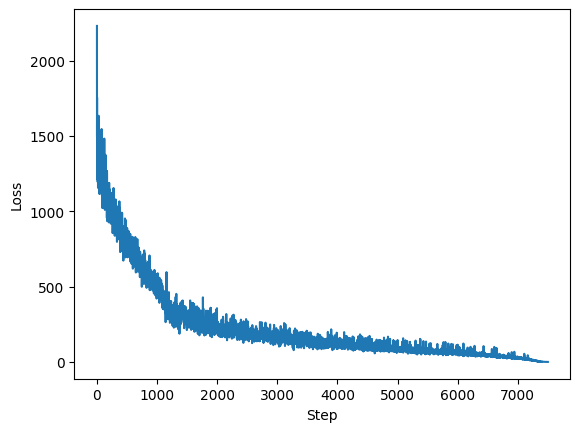

In [90]:
loss_nmf, mat_nmf = recommender(df_reduced, maxim = maxim_nmf,num_steps=7500, k=10)

In [93]:
svd_mat.to_csv("svd_players.csv")

In [94]:
mat_nmf.to_csv("nmf_players.csv")

In [95]:
svd_mat.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,169.004410,66.986680,3.573160,3.622120,2.990359,23.489430,93.001319,88.997949,85.998756,96.001832,...,40.998446,60.997688,29.998863,76.997082,22.999128,20.999204,37.998560,33.998712,52.997991,88.996627
1,184.956829,79.957255,3.499611,3.157241,6.052754,23.413387,92.995185,93.014681,81.016502,91.015069,...,41.015873,61.023615,30.011614,77.029809,23.008904,21.008130,38.014711,34.013163,53.020518,89.034455
2,179.978636,80.006150,3.438107,3.072724,5.975166,24.638901,93.003340,85.994725,82.996740,92.004403,...,41.003283,61.004884,30.002402,77.006165,23.001841,21.001681,38.003042,34.002722,53.004243,89.007126
3,195.051259,94.863917,3.305797,2.635682,3.049457,25.354172,75.995342,91.013310,81.014408,86.011853,...,40.994067,60.991173,29.995659,76.988858,22.996672,20.996961,37.994502,33.995080,52.992331,88.987122
4,193.058350,91.941290,2.726719,1.685114,4.025041,24.914282,68.085251,51.677262,55.748061,60.615049,...,40.988653,60.983118,29.991698,76.978691,22.993635,20.994188,37.989484,33.990591,52.985332,88.975370


In [96]:
mat_nmf.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,25
0,227.320646,0.000293,4.718474e-08,4.203412e-08,4.635358e-08,8.438832e-08,0.000208,0.000010,0.000104,0.000262,...,3.511386e-07,0.000097,1.041508e-07,0.000345,8.459798e-08,7.253532e-08,3.781757e-07,2.939292e-07,0.000034,0.000183
1,228.981763,0.000221,3.259313e-08,3.461008e-08,3.861484e-08,6.949689e-08,0.000130,0.000005,0.000082,0.000158,...,2.534054e-07,0.000123,9.009527e-08,0.000255,6.966955e-08,6.973747e-08,4.069045e-07,2.121192e-07,0.000023,0.000149
2,106.399429,0.000198,2.859369e-08,2.876845e-08,3.205403e-08,4.927889e-08,0.000149,0.000005,0.000073,0.000155,...,2.215332e-07,0.000119,7.919228e-08,0.000291,4.940132e-08,5.515478e-08,3.005635e-07,1.854401e-07,0.000038,0.000289
3,224.762044,0.000076,2.973748e-08,3.393119e-08,3.764864e-08,4.504491e-08,0.000157,0.000005,0.000079,0.000173,...,2.217707e-07,0.000177,8.449106e-08,0.000335,4.515682e-08,6.215011e-08,3.410886e-07,1.856383e-07,0.000025,0.000356
4,131.360509,0.000275,3.633203e-08,3.653809e-08,4.058911e-08,6.111629e-08,0.000181,0.000007,0.000090,0.000207,...,2.776216e-07,0.000131,9.514359e-08,0.000301,6.126813e-08,6.029797e-08,3.525277e-07,2.323903e-07,0.000039,0.000299
